# Analyzing the Parking Violations Issued by New York City (FY16)

As part of New York's open data policy, it makes the full dataset of parking violations issued during each fiscal year. This project will explore the dataset from FY16. The full dataset contains over 10 million observations, but this project will be using a sample of 40,000. The project will also only use data from NYPD Precinct 114 which covers the northwest corner of Queens, including Astoria, Long Island City, and parts of Woodside and Jackson Heights.

The goal of the project is to discover if it is possible to predict the type of violation issued using information that could be known beforehand like vehicle make, plate type, color, etc.

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, cross_validation, neighbors, tree, metrics

from IPython.display import Image
%matplotlib inline

# Set the default figure size for plotting
sns.mpl.rc("figure", figsize=(40,20))  # Larger default plots
sns.set_context("notebook", font_scale=1)  # Larger fonts

In [5]:
df = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2016.csv').sample(40000)

In [6]:
#df2 = pd.read_csv('DOF_Parking_Violation_Codes.csv')

## Exploratory Analysis of Precinct 114

In [95]:
df_astoria = df[df['Violation Precinct'] == 114]

In [96]:
df_astoria.shape

(1080, 43)

## Choosing Predictor Variables

The dataset contains mostly categorical data across its 43 columns. On first observation, there are four columns that contain no data and fifteen more that have missing data. 

In [273]:
df_astoria.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 4595237 to 6830519
Data columns (total 43 columns):
Summons Number                       1080 non-null int64
Plate ID                             1080 non-null object
Registration State                   1080 non-null object
Plate Type                           1080 non-null object
Issue Date                           1080 non-null object
Violation Code                       1080 non-null float64
Vehicle Body Type                    1076 non-null object
Vehicle Make                         1078 non-null object
Issuing Agency                       1080 non-null object
Street Code1                         1080 non-null float64
Street Code2                         1080 non-null float64
Street Code3                         1080 non-null float64
Vehicle Expiration Date              1080 non-null float64
Violation Location                   1080 non-null float64
Violation Precinct                   1080 non-null float64
Issuer P

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7e37fa9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe7fd4660d0>]], dtype=object)

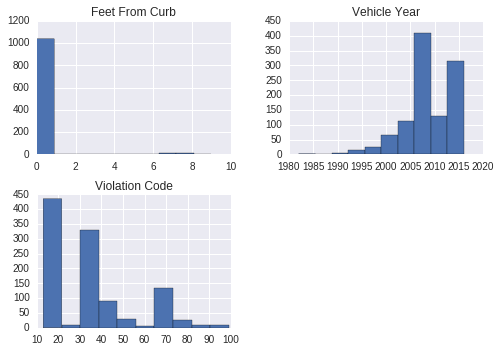

In [321]:
df_astoria_focused.hist()

Looking a little more closely at the data shows that several of the fields are cryptically coded and might take some work to unpack, but there are enough columns that contain understandable information and are either complete or only missing a few values. 

In [275]:
df_astoria.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
4595237,7726280475,R67DNH,NJ,PAS,11/25/2015,37.0,SUBN,CHEVR,T,7990.0,...,BLACK,NaN,0.0,407-2239,0.0,31 4,37-Expired Muni Meter,NaN,NaN,NaN
1801816,8025636203,DPP8365,NY,PAS,08/25/2015,21.0,2DSD,TOYOT,T,7540.0,...,BK,NaN,2005.0,NaN,0.0,52-A,21-No Parking (street clean),NaN,NaN,NaN
4174419,8048210174,GTB3562,NY,PAS,10/26/2015,38.0,4DSD,NISSA,T,64290.0,...,BK,NaN,1999.0,NaN,0.0,27-A,38-Failure to Display Muni Rec,NaN,NaN,NaN
9593078,8194018330,GLH2050,NY,PAS,04/30/2016,72.0,4DSD,BMW,T,7190.0,...,BLACK,NaN,2008.0,NaN,0.0,26 4,72A-Insp Stkr Counterfeit,NaN,NaN,NaN
9556767,8047891558,GR8RLST8,NY,SRF,04/29/2016,37.0,4DSD,CADIL,T,6940.0,...,RD,NaN,2015.0,418-1659,0.0,34 4,37-Expired Muni Meter,NaN,NaN,NaN


In [287]:
# Focusing in on the variables that I think will have the most impact.
df_astoria_focused = df_astoria[['Registration State', 
                                 'Plate Type', 
                                 'Issue Date', 
                                 'Vehicle Make',
                                 'Vehicle Body Type',
                                 'Violation Code', 
                                 'Vehicle Color',
                                 'Vehicle Year',
                                 'Feet From Curb']]

In [288]:
# df.describe doesn't give us a lot of information at this point since the majority of the data is categorical and
# hasn't been converted to dummy variables yet.
df_astoria_focused.describe()

,Violation Code,Vehicle Year,Feet From Curb
count,1080.000000,1080.000000,1080.000000
mean,37.211111,1571.794444,0.212963
std,18.865208,829.297857,1.158047
min,13.000000,0.000000,0.000000
25%,21.000000,1997.750000,0.000000
50%,37.000000,2007.000000,0.000000
75%,40.000000,2013.000000,0.000000
max,99.000000,2016.000000,9.000000


In [343]:
df_astoria_focused.corr()

,Violation Code,Vehicle Year,Feet From Curb
Violation Code,1.000000,0.054223,0.027211
Vehicle Year,0.054223,1.000000,-0.094606
Feet From Curb,0.027211,-0.094606,1.000000


In [289]:
df_astoria_focused.head(5)

,Registration State,Plate Type,Issue Date,Vehicle Make,Vehicle Body Type,Violation Code,Vehicle Color,Vehicle Year,Feet From Curb
4595237,NJ,PAS,11/25/2015,CHEVR,SUBN,37.0,BLACK,0.0,0.0
1801816,NY,PAS,08/25/2015,TOYOT,2DSD,21.0,BK,2005.0,0.0
4174419,NY,PAS,10/26/2015,NISSA,4DSD,38.0,BK,1999.0,0.0
9593078,NY,PAS,04/30/2016,BMW,4DSD,72.0,BLACK,2008.0,0.0
9556767,NY,SRF,04/29/2016,CADIL,4DSD,37.0,RD,2015.0,0.0


### Adding a 'Date' column that has a data type as datetime64

The _Issue Date_ column tells when each ticket was written, but is currently formatted as a string. I'm going to add a _Date_ column that will hold those dates in a _datetime64_ format.


In [293]:
type(df_astoria_focused.iloc[0]['Issue Date'])

str

In [295]:
df_astoria_focused['Date'] = pd.to_datetime(df_astoria_focused['Issue Date'],infer_datetime_format=True)


/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [296]:
# And dropping the 'Issue Date' column
df_astoria_focused.drop('Issue Date', axis=1)

,Registration State,Plate Type,Vehicle Make,Vehicle Body Type,Violation Code,Vehicle Color,Vehicle Year,Feet From Curb,Date
4595237,NJ,PAS,CHEVR,SUBN,37.0,BLACK,0.0,0.0,2015-11-25
1801816,NY,PAS,TOYOT,2DSD,21.0,BK,2005.0,0.0,2015-08-25
4174419,NY,PAS,NISSA,4DSD,38.0,BK,1999.0,0.0,2015-10-26
9593078,NY,PAS,BMW,4DSD,72.0,BLACK,2008.0,0.0,2016-04-30
9556767,NY,SRF,CADIL,4DSD,37.0,RD,2015.0,0.0,2016-04-29
4070475,NY,PAS,DODGE,SUBN,21.0,GY,0.0,0.0,2015-11-06
1905434,NY,PAS,ME/BE,SUBN,37.0,GY,2012.0,0.0,2015-08-26
7136926,NY,COM,DODGE,VAN,19.0,WHITE,2013.0,0.0,2016-01-28
857982,NY,PAS,VOLKS,4DSD,20.0,BLUE,2003.0,0.0,2015-07-17
830912,NY,COM,CHEVR,VAN,21.0,WH,2006.0,0.0,2015-07-21


### Changing the _Vehicle Year_ column data type from string to integer

In [297]:
# Casting the 'Vehicle Year' column to integers

df_astoria_focused['Vehicle Year'] = df_astoria_focused['Vehicle Year'].astype(int)

/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


The value 0 comes up 235 in the _Vehicle Year_ column. I will replace those with the median of the column.

In [298]:
df_astoria_focused.replace({'Vehicle Year' : {0: df_astoria_focused['Vehicle Year'].median()}}, inplace=True) 

## Fixing Inconsistencies in Values and Dealing with Missing Values.

Looking at df_astoria_focused.info() shows me that _Vehicle Make_, _Vehicle Color_, and _Vehicle Body Type_ are each missing a few values, but before I deal with those, I'm going to make the values in these fields more consistent. As an example, the _Vehicle Color_ column has the following variations of black: BK, BLACK, BLK, and possibly BL (but I'm going to assume that is blue).

In [300]:
df_astoria_focused.info()
df_astoria_focused['Vehicle Color'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 4595237 to 6830519
Data columns (total 10 columns):
Registration State    1080 non-null object
Plate Type            1080 non-null object
Issue Date            1080 non-null object
Vehicle Make          1078 non-null object
Vehicle Body Type     1076 non-null object
Violation Code        1080 non-null float64
Vehicle Color         1077 non-null object
Vehicle Year          1080 non-null int64
Feet From Curb        1080 non-null float64
Date                  1080 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 92.8+ KB


GY       177
BK       171
WH       165
WHITE     91
BLACK     81
BL        62
GREY      47
RD        41
BLUE      36
SILVE     34
RED       32
GR        30
BROWN     14
GREEN     13
TN        12
OTHER      9
BR         8
BLK        7
YW         7
MR         7
TAN        6
GL         5
GOLD       5
OR         4
LT/        2
YELLO      2
PURPL      2
DK/        1
BK/GY      1
GRY        1
GRAY       1
LTG        1
SILV       1
ORANG      1
Name: Vehicle Color, dtype: int64

### Cleaning up the values in the _Vehicle Color_ and _Vehicle Body Type_ fields

Beyond just making all of the color values consistent, there are a few values (with low counts) that aren't entirely clear to me. Since the dataset already contains _OTHER_ as an option, these odd ones will be folded into it.

In [301]:
# Cleaning up the values in the 'Vehicle Color' field
df_astoria_focused.replace({'Vehicle Color': {'BL':'BLACK',
                                              'BK':'BLACK',
                                              'BLK':'BLACK',
                                              'BLCK':'BLACK',
                                              'BLACL':'BLACK',
                                              'BK/' : 'BLACK',
                                              'WH':'WHITE',
                                              'WHTIE':'WHITE',
                                              'WH':'WHITE',
                                              'WHTE': 'WHITE',
                                              'WH/' : 'WHITE',
                                              'GY' : 'GREY',
                                              'GY/': 'GREY',
                                              'GRY' : 'GREY',
                                              'GAY' : 'GREY',
                                              'GR' : 'GREY',
                                              'GRAY': 'GREY',
                                              'RD' : 'RED',
                                              'TN': 'TAN',
                                              'YW' : 'YELLO',
                                              'BR' : 'BROWN',
                                              'BRN' : 'BROWN',
                                              'BROW' : 'BROWN',
                                              'BWN' : 'BROWN',
                                              'GL' : 'GOLD', 
                                              'ORAN': 'ORANG',
                                              'GRN' :'GREEN',
                                              'GN' : 'GREEN',
                                              'BLU' : 'BLUE',
                                              'SLIVE' : 'SILVE',
                                              'YL' : 'YELLO',
                                              'YLLW' :'YELLO',
                                              'OR' : 'ORANG',
                                              'BK/GY' : 'BLACK',
                                              'LT/' : 'OTHER',
                                              'DK/' : 'OTHER',
                                              'LTG': 'OTHER',
                                              'SILV' : 'SILVE',
                                              'MR' : 'RED'}}, inplace=True)
df_astoria_focused['Vehicle Color'].value_counts()

BLACK    322
WHITE    256
GREY     256
RED       80
BLUE      36
SILVE     35
BROWN     22
TAN       18
OTHER     13
GREEN     13
GOLD      10
YELLO      9
ORANG      5
PURPL      2
Name: Vehicle Color, dtype: int64

In [305]:
# Cleaning up the values in the 'Vehicle Body Type' field
df_astoria_focused.replace({'Vehicle Body Type': {'P-U':'PICK',
                                                  'TK':'PICK'
                                         }}, inplace=True)
df_astoria_focused['Vehicle Body Type'].value_counts()

SUBN    399
4DSD    397
VAN      91
2DSD     53
PICK     38
DELV     29
SDN      28
TRAC      9
CONV      7
TAXI      6
MCY       4
UTIL      4
REFG      2
T/CR      2
BOAT      2
FLAT      1
BUS       1
TOW       1
LIM       1
TRLR      1
Name: Vehicle Body Type, dtype: int64

### Missing Values
I will be imputing the missing _Vehicle Color_ fields with BLACK, which is the most frequent value. The missing values in _Vehicle Make_ will be filled with HONDA, and the _Vehicle Body Type_ field's missing values will become SUBN, which are the most frequent values in those fields.

In [307]:
df_astoria_focused['Vehicle Color'].fillna('BLACK', inplace=True)
df_astoria_focused['Vehicle Make'].fillna('HONDA', inplace=True)
df_astoria_focused['Vehicle Body Type'].fillna('SUBN', inplace=True)

In [308]:
df_astoria_focused.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 4595237 to 6830519
Data columns (total 10 columns):
Registration State    1080 non-null object
Plate Type            1080 non-null object
Issue Date            1080 non-null object
Vehicle Make          1080 non-null object
Vehicle Body Type     1080 non-null object
Violation Code        1080 non-null float64
Vehicle Color         1080 non-null object
Vehicle Year          1080 non-null int64
Feet From Curb        1080 non-null float64
Date                  1080 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 92.8+ KB


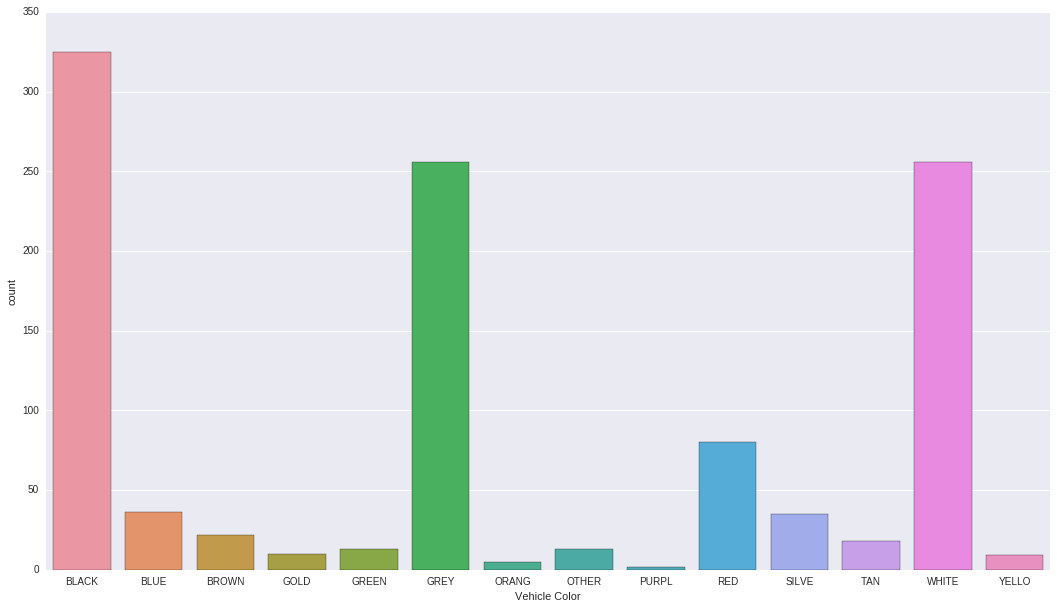

In [309]:
plt.figure(figsize=(18,10))
sns.countplot(x="Vehicle Color", data=df_astoria_focused.sort_values(by='Vehicle Color'));

### Counts by Plate Type

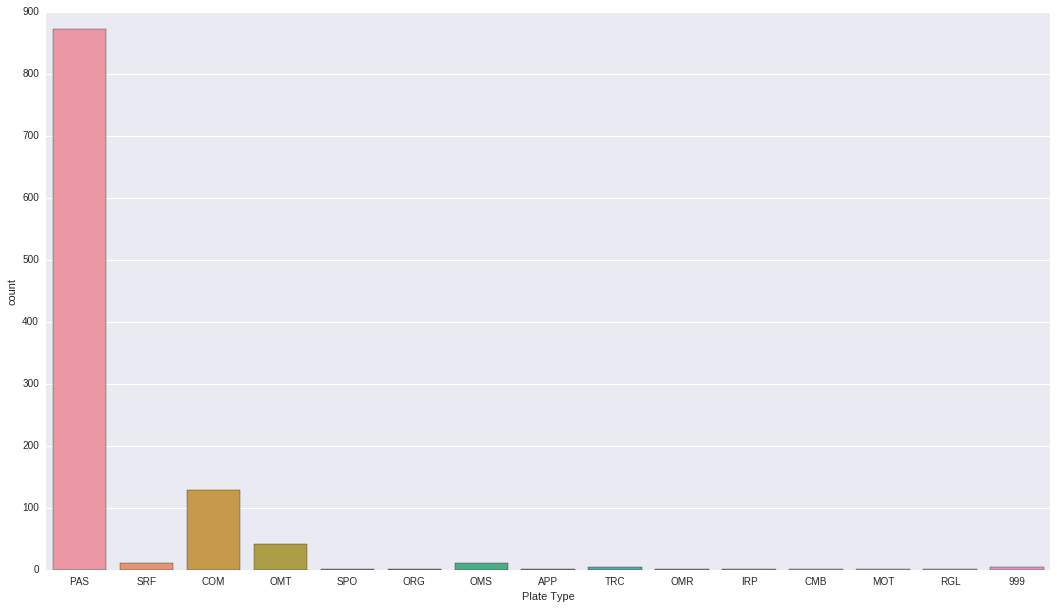

In [310]:
plt.figure(figsize=(18,10))
sns.countplot(x="Plate Type", data=df_astoria_focused);

### Counts by Vehicle Body Type

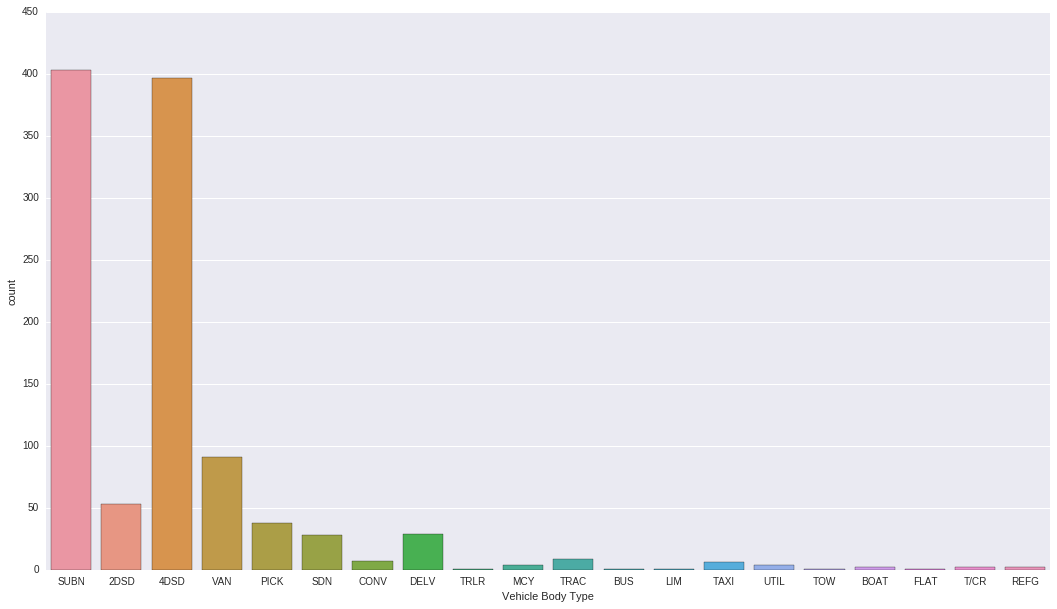

In [311]:
plt.figure(figsize=(18,10))
sns.countplot(x="Vehicle Body Type", data=df_astoria_focused, orient="h");

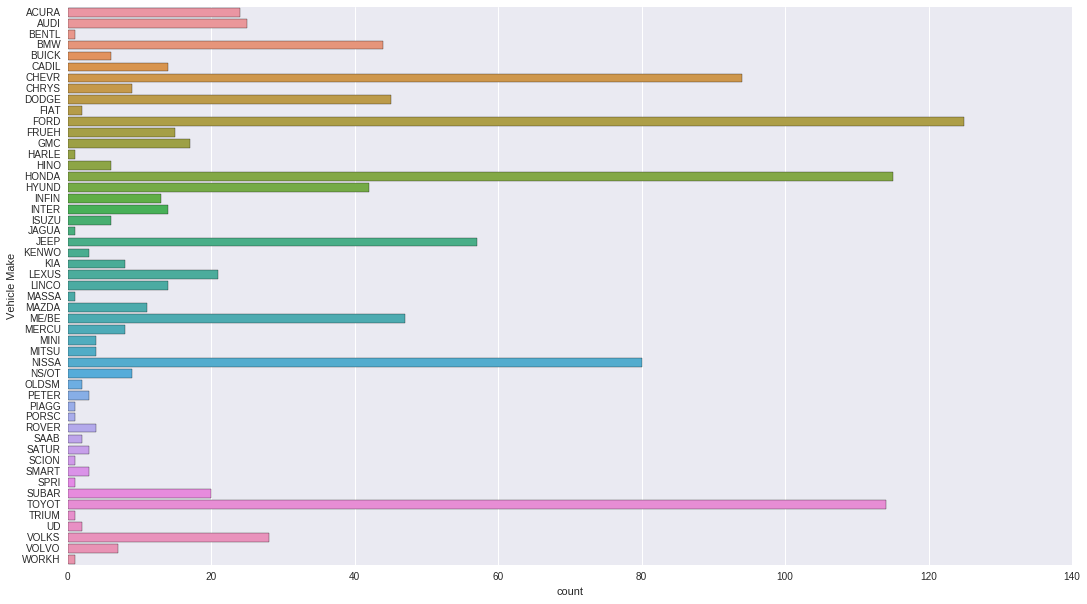

In [312]:
plt.figure(figsize=(18,10))
sns.countplot(y="Vehicle Make", data=df_astoria_focused.sort_values(by='Vehicle Make'), orient="h");

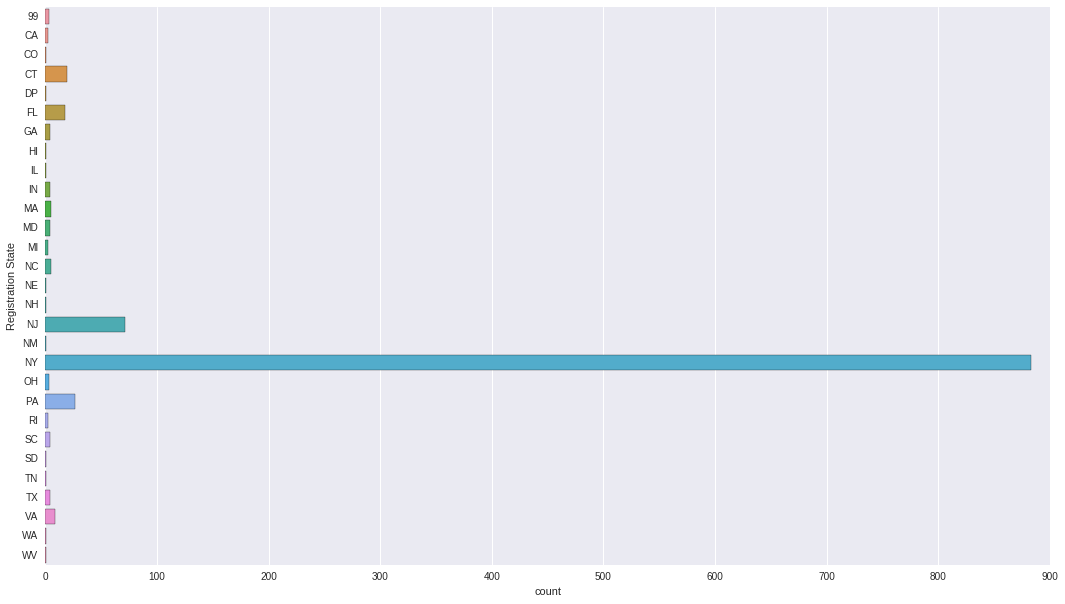

In [313]:
plt.figure(figsize=(18,10))
sns.countplot(y="Registration State", data=df_astoria_focused.sort_values(by='Registration State'));

## How Do these Predictor Variables Relate to The Dependent Variable

Here's a table that explains the different violation codes:

In [329]:
df2 = pd.read_csv('DOF_Parking_Violation_Codes.csv')
df2

,CODE,DEFINITION,Manhattan 96th St. & below,All Other Areas
0,10,"Stopping, standing or parking where a sign, st...",$115,$115
1,11,Hotel Loading/Unloading: Standing or parking w...,$115,$115
2,12,Snow Emergency: Standing or parking where stan...,$95,$95
3,13,Taxi Stand: Standing or parking where standing...,$115,$115
4,14,General No Standing: Standing or parking where...,$115,$115
5,16,Truck Loading/Unloading: Standing or parking w...,$95,$95
6,17,Authorized Vehicles Only: Standing or parking ...,$95,$95
7,18,Bus Lane: Standing or parking where standing i...,$115,$115
8,19,Bus Stop: Standing or parking where standing i...,$115,$115
9,20,General No Parking: No parking where parking i...,$65,$60


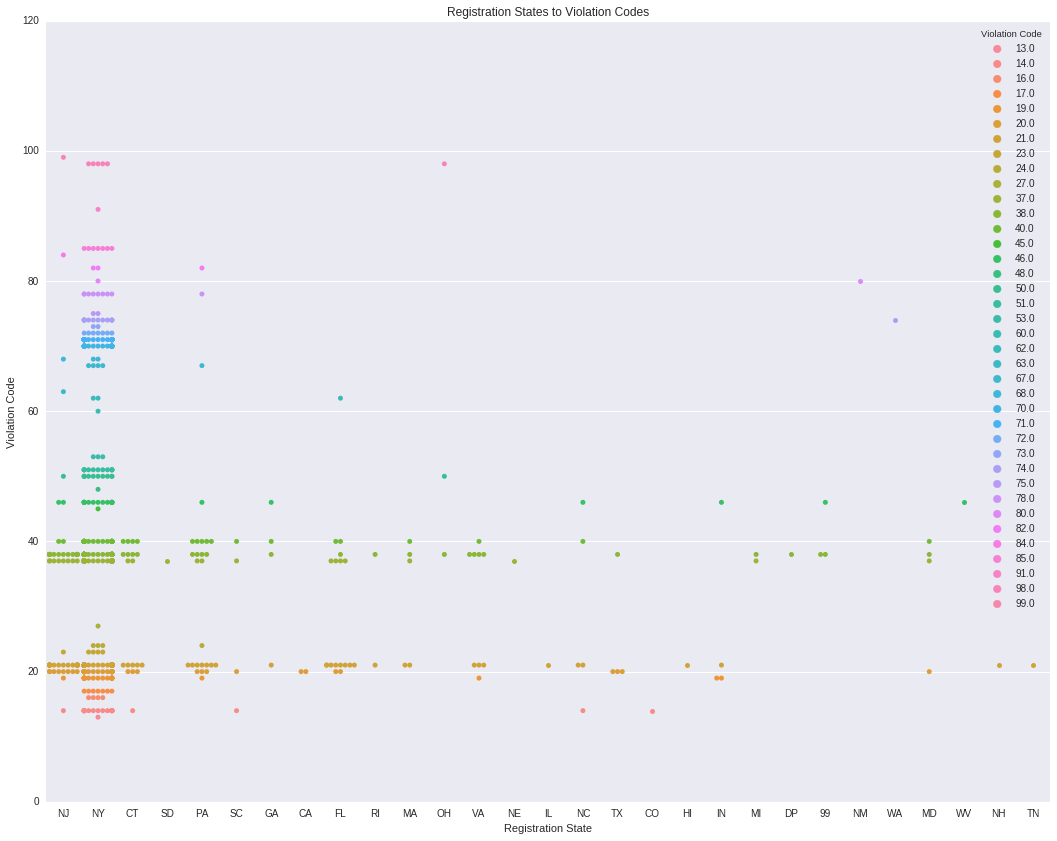

In [336]:
plt.figure(figsize=(18,14))
sns.swarmplot(x='Registration State', y='Violation Code', data=df_astoria_focused, hue='Violation Code')
plt.title('Registration States to Violation Codes')

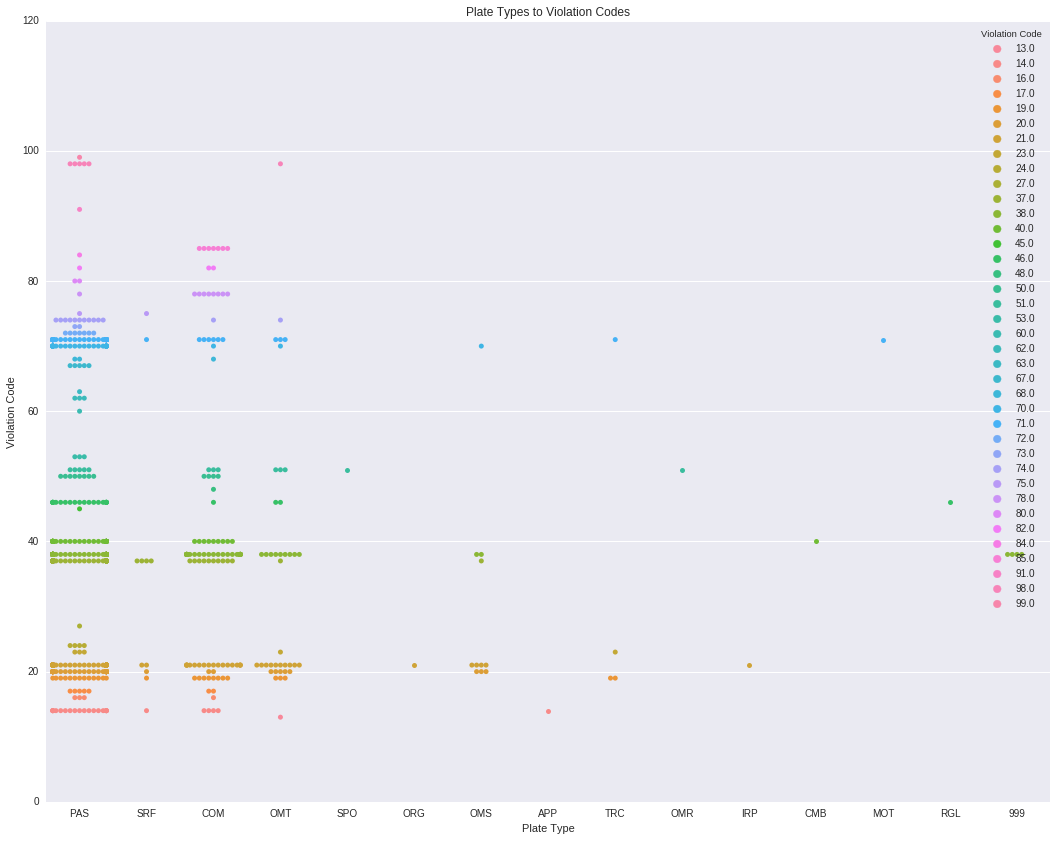

In [330]:
plt.figure(figsize=(18,14))
sns.swarmplot(x='Plate Type', y='Violation Code', data=df_astoria_focused, hue='Violation Code')
plt.title('Plate Types to Violation Codes')

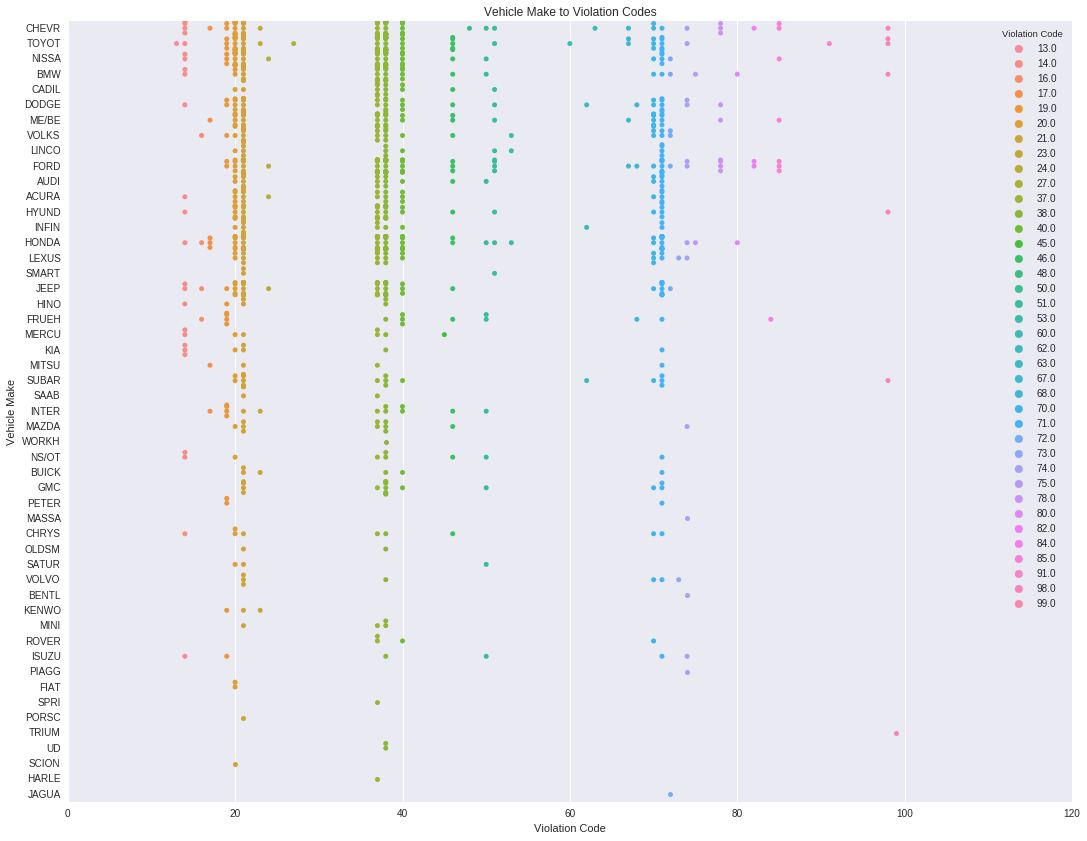

In [333]:
plt.figure(figsize=(18,14))
sns.swarmplot(x='Violation Code', y='Vehicle Make', data=df_astoria_focused, hue='Violation Code')
plt.title('Vehicle Make to Violation Codes')

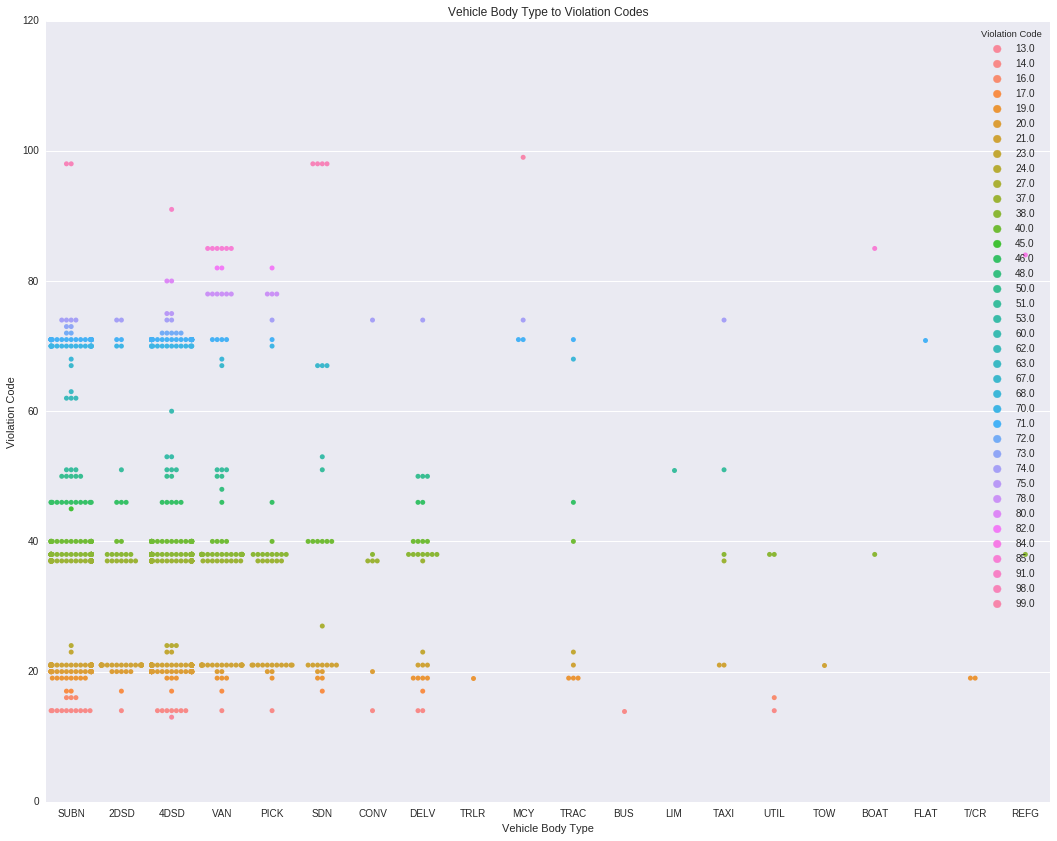

In [339]:
plt.figure(figsize=(18,14))
sns.swarmplot(x='Vehicle Body Type', y='Violation Code', data=df_astoria_focused, hue='Violation Code')
plt.title('Vehicle Body Type to Violation Codes')

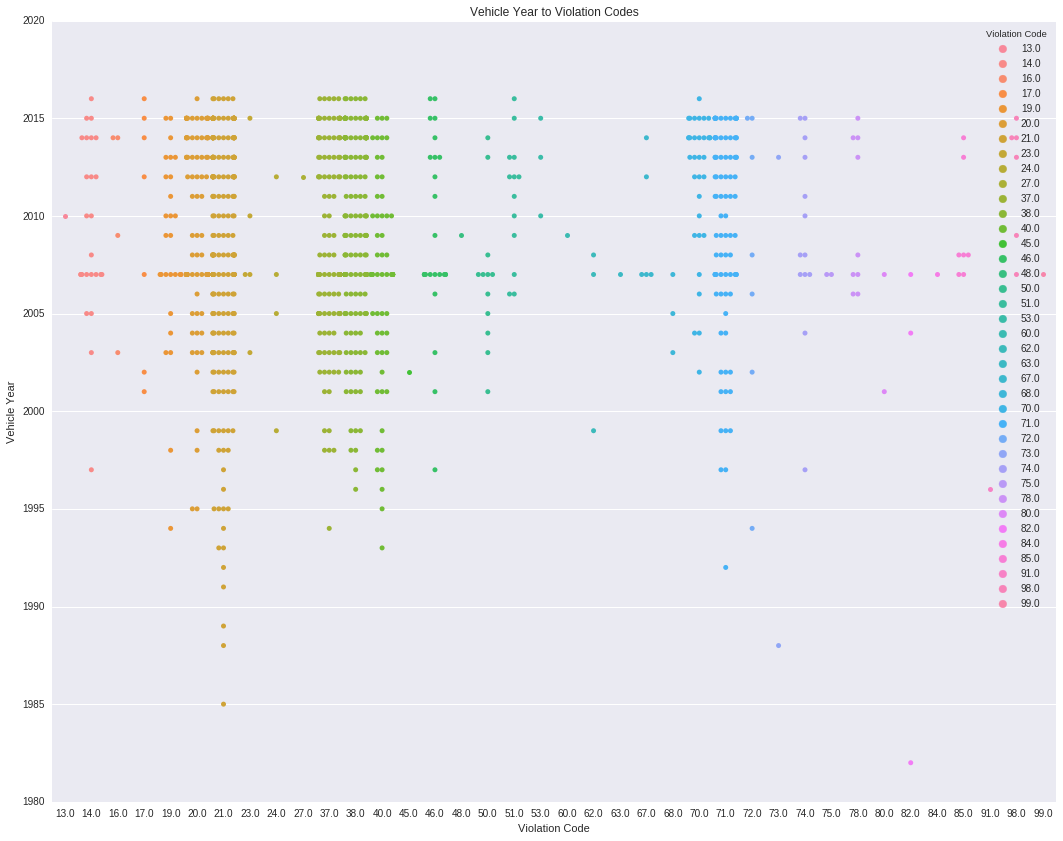

In [340]:
plt.figure(figsize=(18,14))
sns.swarmplot(x='Violation Code', y='Vehicle Year', data=df_astoria_focused, hue='Violation Code')
plt.title('Vehicle Year to Violation Codes')

## Making Dummy Variables

Since six of the nine fields (including the outcome variable: _Violation Code_) are categorical, they are going to be broken out into dummy variables. I will also be separating the outcome variables into a separate dataframe in preparation for the analysis.

In [286]:
df_astoria['Violation Location'].value_counts()

114.0    1080
Name: Violation Location, dtype: int64

In [314]:
state_dummies = pd.get_dummies(df_astoria_focused['Registration State'], prefix='State', drop_first=True)
plate_type_dummies = pd.get_dummies(df_astoria_focused['Plate Type'], prefix='Plate_Type', drop_first=True)
vehicle_make_dummies = pd.get_dummies(df_astoria_focused['Vehicle Make'], prefix='Make', drop_first=True)
body_type_dummies = pd.get_dummies(df_astoria_focused['Vehicle Body Type'], prefix='Body Type', drop_first=True)
vehicle_color_dummies = pd.get_dummies(df_astoria_focused['Vehicle Color'], prefix='Color', drop_first=True)
vehicle_year = df_astoria_focused['Vehicle Year']
date = df_astoria_focused['Date']

violation_code_dummies = pd.get_dummies(df_astoria_focused['Violation Code'])

In [315]:
df_dummies = pd.concat([state_dummies, 
               plate_type_dummies, 
               vehicle_make_dummies, 
               body_type_dummies, 
               vehicle_color_dummies], axis=1)

df_dummies['Vehicle Year'] = vehicle_year
df_dummies['Date'] = date

y = violation_code_dummies

In [316]:
len(vehicle_year)

1080

In [317]:
df_dummies.head()

,State_CA,State_CO,State_CT,State_DP,State_FL,State_GA,State_HI,State_IL,State_IN,State_MA,...,Color_ORANG,Color_OTHER,Color_PURPL,Color_RED,Color_SILVE,Color_TAN,Color_WHITE,Color_YELLO,Vehicle Year,Date
4595237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007,2015-11-25
1801816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005,2015-08-25
4174419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999,2015-10-26
9593078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008,2016-04-30
9556767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015,2016-04-29


In [318]:
df_dummies.sort_values(by='Date', inplace=True)

In [319]:
df_dummies.index = df_dummies['Date']
del df_dummies['Date']
df_dummies.columns

Index([u'State_CA', u'State_CO', u'State_CT', u'State_DP', u'State_FL',
       u'State_GA', u'State_HI', u'State_IL', u'State_IN', u'State_MA',
       ...
       u'Color_GREY', u'Color_ORANG', u'Color_OTHER', u'Color_PURPL',
       u'Color_RED', u'Color_SILVE', u'Color_TAN', u'Color_WHITE',
       u'Color_YELLO', u'Vehicle Year'],
      dtype='object', length=125)

In [320]:
df_dummies.head()

,State_CA,State_CO,State_CT,State_DP,State_FL,State_GA,State_HI,State_IL,State_IN,State_MA,...,Color_GREY,Color_ORANG,Color_OTHER,Color_PURPL,Color_RED,Color_SILVE,Color_TAN,Color_WHITE,Color_YELLO,Vehicle Year
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2007
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1998
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2011
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013


## Looking for Correllated Variables

The following chart is exceedingly difficult to read in it's current state, but there do appear to be some combinations of variables that are highly correllated. 

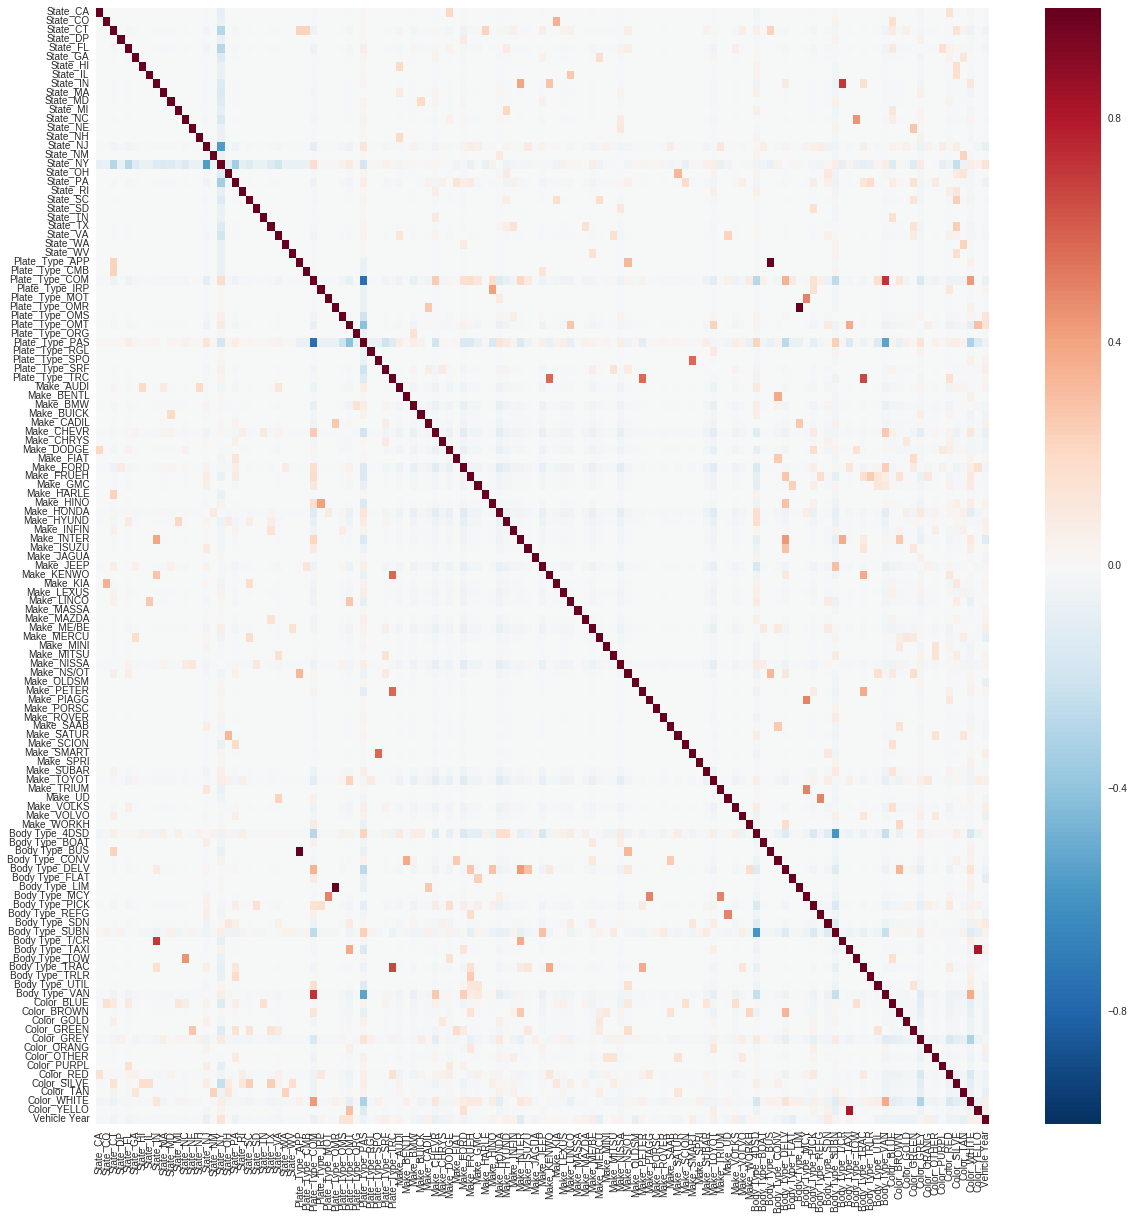

In [347]:
plt.figure(figsize=(20,20))
sns.heatmap(df_dummies.corr())